## Transfer Learning with TensorFlow Part 3: Scaling up

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

🔑 **Note**: You haven't forgotten the machine learning practitioners motto have you? "Experiment, experiment, experiment."

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper's](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) results with 10% of data**.

![ScalingUpTransferLearning.png](Images/ScalingUpTransferLearning.png)

## What we're going to cover

We're going to go through the follow with TensorFlow:

* Downloading and preparing 10% of the Food101 data (10% of training data)
* Training a feature extraction transfer learning model on 10% of the Food101 training data
* Fine-tuning our feature extraction model
* Saving and loaded our trained model
* Evaluating the performance of our Food Vision model trained on 10% of the training data
    * Finding our model's most wrong predictions
* Making predictions with our Food Vision model on custom images of food

## Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the GitHub repo.

In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-14 09:40:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-14 09:40:47 (25.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

Init Plugin
Init Graph Optimizer
Init Kernel


## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook)](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-12-14 09:43:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.41.80, 172.217.165.16, 142.251.32.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.41.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  18.8MB/s    in 83s     

2022-12-14 09:45:19 (18.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Metal device set to: Apple M1


2022-12-14 09:47:02.392218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 09:47:02.392338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images).

## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

1. A `[ModelCheckpoint callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)` to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
2. Data augmentation built right into the model
3. A headless (no top layers) `[EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0)` architecture from `tf.keras.applications` as our base model
4. A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
5. Categorical crossentropy as the loss function since we're dealing with more than two classes
6. The Adam optimizer with the default settings
7. Fitting for 5 full passes on the training data while evaluating on 15% of the test data
It seems like a lot but these are all things we've covered before in the Transfer Learning in TensorFlow Part 2: Fine-tuning notebook.

Let's start by creating the `ModelCheckpoint callback`.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

Beautiful! We'll be able to insert the `data_augmentation` `Sequential model` as a layer in our `Functional API` model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense layer`.

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
#x = data_augmentation(inputs) # augment images (only happens during training)
#x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [10]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


How would our model summary look like if we add the data augmentation layer:
![modelSummaryWithDataAugmentation.png](Images/modelSummaryWithDataAugmentation.png)

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


2022-12-14 10:01:28.144772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 10:01:28.156365: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-14 10:01:28.156736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 3.1963 - accuracy: 0.3130

2022-12-14 10:02:33.114824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 95s 376ms/step - loss: 3.1963 - accuracy: 0.3130 - val_loss: 2.4241 - val_accuracy: 0.4661
Epoch 2/5
237/237 [==============================] - 89s 378ms/step - loss: 1.9300 - accuracy: 0.5687 - val_loss: 2.0169 - val_accuracy: 0.5164
Epoch 3/5
237/237 [==============================] - 89s 376ms/step - loss: 1.5279 - accuracy: 0.6470 - val_loss: 1.8838 - val_accuracy: 0.5220
Epoch 4/5
237/237 [==============================] - 88s 373ms/step - loss: 1.2851 - accuracy: 0.6998 - val_loss: 1.7954 - val_accuracy: 0.5358
Epoch 5/5
237/237 [==============================] - 89s 374ms/step - loss: 1.1133 - accuracy: 0.7472 - val_loss: 1.7589 - val_accuracy: 0.5384


In [12]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 201s 254ms/step - loss: 1.5320 - accuracy: 0.6009


[1.5319923162460327, 0.6009109020233154]

Well it looks like we just beat our **baseline (the results from the original Food101 paper)** with 10% of the data! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

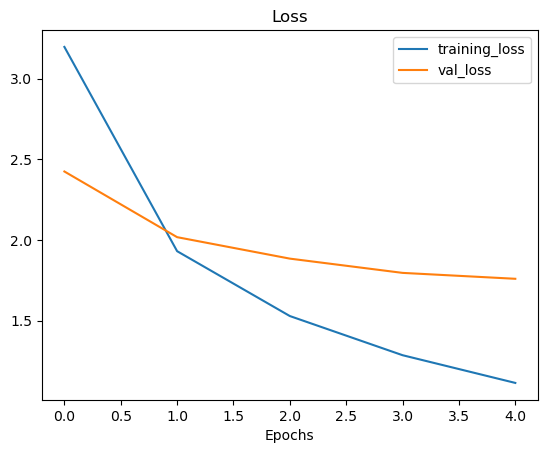

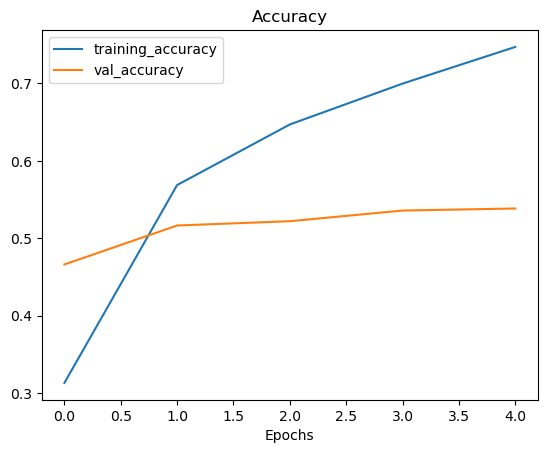

In [13]:
plot_loss_curves(history_all_classes_10_percent)

🤔 **Question**: What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint callback`, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

#### We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![FineTuneAllData.png](Images/FineTuneAllData.png)

In [15]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling True
output_layer True


In [17]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10


2022-12-14 10:14:28.129114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 1.0581 - accuracy: 0.7666

2022-12-14 10:15:34.619980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 99s 406ms/step - loss: 1.0581 - accuracy: 0.7666 - val_loss: 1.7034 - val_accuracy: 0.5572
Epoch 6/10
237/237 [==============================] - 94s 396ms/step - loss: 0.9006 - accuracy: 0.8029 - val_loss: 1.6566 - val_accuracy: 0.5707
Epoch 7/10
237/237 [==============================] - 93s 390ms/step - loss: 0.8141 - accuracy: 0.8234 - val_loss: 1.6277 - val_accuracy: 0.5773
Epoch 8/10
237/237 [==============================] - 93s 393ms/step - loss: 0.7378 - accuracy: 0.8434 - val_loss: 1.6207 - val_accuracy: 0.5773
Epoch 9/10
237/237 [==============================] - 95s 400ms/step - loss: 0.6722 - accuracy: 0.8618 - val_loss: 1.6061 - val_accuracy: 0.5781
Epoch 10/10
237/237 [==============================] - 95s 399ms/step - loss: 0.6091 - accuracy: 0.8776 - val_loss: 1.5916 - val_accuracy: 0.5829


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [20]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 201s 255ms/step - loss: 1.3731 - accuracy: 0.6345


[1.373124122619629, 0.6344950795173645]

Hmm... it seems like our model got a slight boost from fine-tuning.

We might get a better picture by using our `compare_historys()` function and seeing what the training curves say.

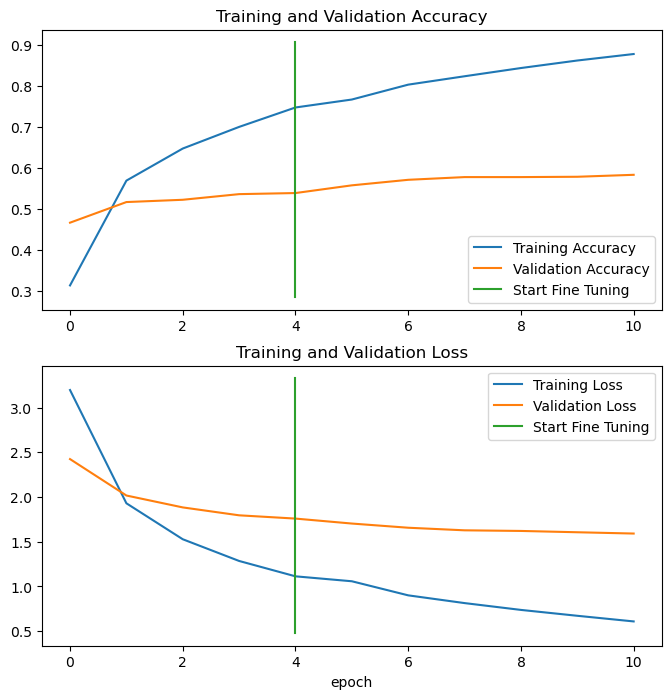

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on `[ImageNet](http://www.image-net.org/index)` which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the save() method.

In [22]:
# # Save model to drive so it can be used later 
model.save("tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

2022-12-14 10:34:00.982458: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: tensorflow_course/101_food_class_10_percent_saved_big_dog_model/assets


## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

🔑 Note: Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [23]:
# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
model = tf.keras.models.load_model("tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
# model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

To make sure our loaded model is indead a trained model, let's evaluate its performance on the test dataset.

In [24]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

2022-12-14 10:37:34.559213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 202s 254ms/step - loss: 1.3731 - accuracy: 0.6345


(1.373124122619629, 0.6344950795173645)

Wonderful! It looks like our loaded model is performing just as well as it was before we saved it. Let's make some predictions.

## Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [25]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

2022-12-14 10:41:00.202189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 193s 244ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

So if we had 25250 images in the test dataset, how many predictions do you think we should have?

In [26]:
# How many predictions are there?
len(pred_probs)

25250

And if each image could be one of 101 classes, how many predictions do you think we'll have for each image?

In [27]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

What we've got is often referred to as a **predictions probability tensor (or array).**

Let's see what the first 10 look like.

In [28]:
# How do they look?
pred_probs[:10]

array([[4.6333060e-01, 4.0311314e-04, 2.8292799e-02, ..., 9.7504919e-05,
        9.5193917e-03, 2.7752830e-02],
       [8.2804316e-01, 2.3948417e-06, 1.0721333e-02, ..., 1.7812252e-03,
        1.0856015e-05, 2.7124666e-05],
       [4.3187127e-01, 2.6519303e-03, 7.9524312e-03, ..., 1.3972495e-03,
        1.1103916e-03, 2.3763678e-03],
       ...,
       [4.8033455e-01, 1.2655139e-06, 1.8519061e-03, ..., 4.0695923e-03,
        4.4991120e-04, 1.7438193e-04],
       [8.9493833e-02, 6.4306491e-04, 1.9437551e-01, ..., 1.1267790e-03,
        2.8893934e-04, 1.0265493e-03],
       [3.9384925e-01, 1.1526328e-06, 5.9160840e-04, ..., 3.5678050e-03,
        1.9468340e-05, 2.8075138e-03]], dtype=float32)

Alright, it seems like we've got a bunch of tensors of really small numbers, how about we zoom into one of them?

In [29]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.6333060e-01 4.0311314e-04 2.8292799e-02 1.1263692e-05 1.8533790e-05
 4.9124810e-05 2.7621083e-04 2.2966360e-05 2.2234671e-02 4.7968869e-04
 7.7166638e-05 1.2222146e-04 1.8734071e-02 4.7347753e-06 9.4871772e-03
 2.3839227e-03 3.4883452e-04 3.4984946e-04 2.4990684e-03 1.2776267e-05
 1.1767619e-03 8.1302749e-04 1.1679590e-03 3.8783514e-04 1.8433323e-03
 1.5395688e-03 5.6659528e-03 1.9073962e-04 1.0075646e-02 1.0533701e-03
 1.0717109e-05 2.6884074e-03 7.8578084e-04 4.1884101e-05 4.1852050e-04
 3.5180565e-05 9.7689556e-04 7.9200213e-04 8.3027268e-03 9.2728628e-04
 2.8006427e-04 1.1410395e-03 1.2154925e-03 3.8102182e-05 3.3681540e-04
 8.3888444e-04 7.9777365e-04 1.3054571e-04 2.9607880e-05 7.2829440e-02
 1.4967705e-03 1.4155793e-04 1.2905307e-01 1.8188610e-03 2.8464090e-04
 1.8853616e-02 5.8262341e-04 9.8455453e-04 9.5964093e-03 5.8468526e-05
 3.9434444e-06 1.3572454e-03 9.1785379e-04 8.

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax")`, it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

🔑 **Note**: Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [30]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 43,  0, 78, 29,  0, 85,  0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our test_data object (which is in the form of a `tf.data.Dataset`) using the `unbatch()` method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in `one-hot encoded` format, we'll take use the argmax() method to return the index of the label.

🔑 **Note**: This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [31]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since test_data isn't shuffled, the y_labels array comes back in the same order as the pred_classes array.

The final check is to see how many labels we've got.

In [32]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

As expected, the number of labels matches the number of images we've got. Time to compare our model's predictions with the ground truth labels.

## Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's `accuracy_score()` function which compares `truth labels` to `predicted labels` and returns an `accuracy score`.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [33]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6344950495049505

In [34]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 3.001241399847032e-08


Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [35]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [36]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

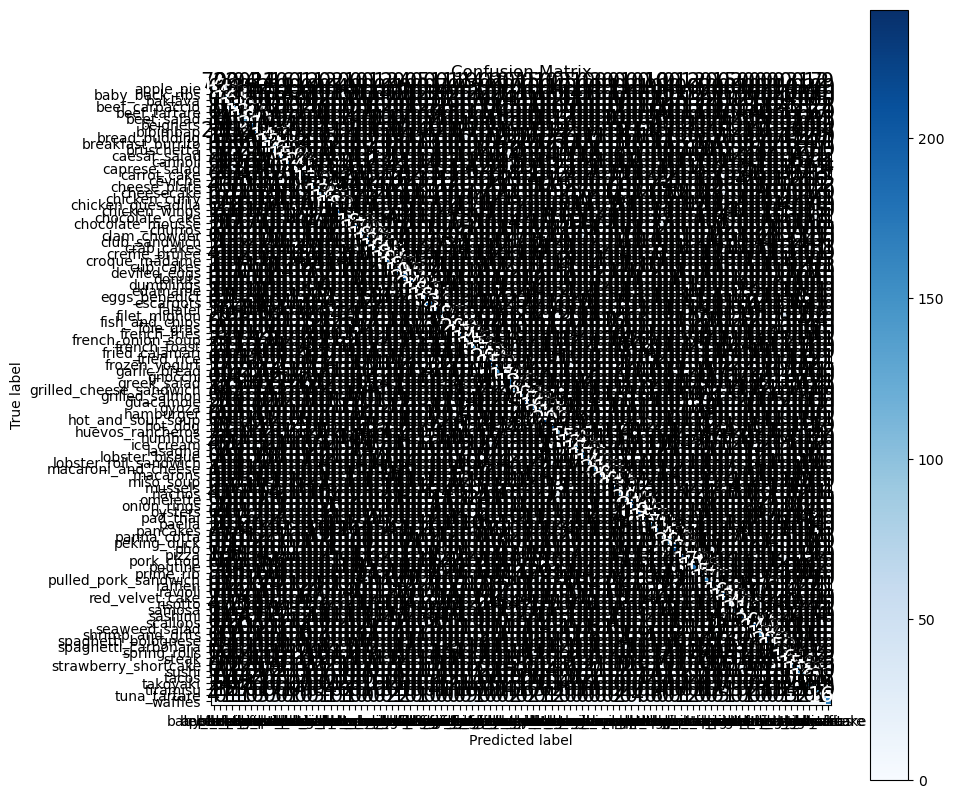

In [37]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes,classes=class_names,figsize=(10,10) )

In [39]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes,classes=class_names,figsize=(100,100), text_size=20 )

In [40]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

Right now our predictions and truth labels are in the form of integers, however, they'll be much easier to understand if we get their actual names. We can do so using the `class_names` attribute on our `test_data` object.

In [41]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Woah! Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.28      0.31       250
           1       0.64      0.65      0.65       250
           2       0.63      0.68      0.65       250
           3       0.66      0.66      0.66       250
           4       0.52      0.57      0.54       250
           5       0.44      0.49      0.46       250
           6       0.75      0.76      0.75       250
           7       0.76      0.84      0.80       250
           8       0.41      0.41      0.41       250
           9       0.51      0.59      0.55       250
          10       0.55      0.48      0.51       250
          11       0.59      0.66      0.62       250
          12       0.70      0.62      0.66       250
          13       0.64      0.50      0.56       250
          14       0.60      0.58      0.59       250
          15       0.43      0.44      0.43       250
          16       0.67      0.56      0.61       250
          17       0.43    

The `classification_report()` outputs the `precision`, `recall` and `f1-score`'s per class.

A reminder:

**Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
**Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
**F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [43]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.35714285714285715,
  'recall': 0.28,
  'f1-score': 0.3139013452914798,
  'support': 250},
 '1': {'precision': 0.6442687747035574,
  'recall': 0.652,
  'f1-score': 0.6481113320079525,
  'support': 250},
 '2': {'precision': 0.6259259259259259,
  'recall': 0.676,
  'f1-score': 0.6499999999999999,
  'support': 250},
 '3': {'precision': 0.6573705179282868,
  'recall': 0.66,
  'f1-score': 0.6586826347305389,
  'support': 250},
 '4': {'precision': 0.5201465201465202,
  'recall': 0.568,
  'f1-score': 0.5430210325047801,
  'support': 250},
 '5': {'precision': 0.4392857142857143,
  'recall': 0.492,
  'f1-score': 0.4641509433962264,
  'support': 250},
 '6': {'precision': 0.7450980392156863,
  'recall': 0.76,
  'f1-score': 0.7524752475247525,
  'support': 250},
 '7': {'precision': 0.7644927536231884,
  'recall': 0.844,
  'f1-score': 0.8022813688212928,
  'support': 250},
 '8': {'precision': 0.408, 'recall': 0.408, 'f1-score': 0.408, 'support': 250},
 '9': {'precision': 0.5121